### Part 1 - Imports

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datasets import load_metric, load_dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import lightning as L
import numpy as np
from torch import nn, optim
from rouge_score import rouge_scorer

### Part 2 - Data Loading and Preprocessing

In [7]:
class CNNDailyMailDataset(Dataset):
    """
    class CNNDailyMailDataset

    Parameters:
    - tokenizer (transformers): tokenizer used.
    - max_length (int): max_lenght of str.
    """
    def __init__(self, tokenizer, max_length=512):
        self.dataset = load_dataset('cnn_dailymail', '3.0.0', split='train')
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        """
        def len

        Return:
        - len(self.dataset) (int): size of the dataset.
        """
        return len(self.dataset)

    def __getitem__(self, idx):
        """
        def getitem

        Parameters:
        - idx (int): index of the dataset

        Return:
        - inputs
        - labels.
        """
        if idx < self.len:
            article = self.dataset[idx]['article']
            summary = self.dataset[idx]['highlights']
            inputs = self.tokenizer(article, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt')
            labels = self.tokenizer(summary, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt').input_ids
            return inputs.input_ids.squeeze(), labels.squeeze()

        else:
            print('Error, idx out of range...')

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})
dataset = CNNDailyMailDataset(tokenizer)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


### Part 3 - Model Definition

In [40]:
import pytorch_lightning as L

class GPT2SummarizationModel(L.LightningModule):
    """
    class GPT2SummarizationModel

    Parameters:
    - model_name (str): model used.
    - lr (float): learning rate lr.
    """
    def __init__(self, model_name='gpt2', lr=5e-5):
        super(GPT2SummarizationModel, self).__init__()
        self.model = GPT2LMHeadModel.from_pretrained(model_name)
        self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        self.lr = lr
        self.train_loss = []

        if self.tokenizer.pad_token is None:
            self.tokenizer.add_special_tokens({'pad_token': self.tokenizer.eos_token})
            self.model.resize_token_embeddings(len(self.tokenizer))

    def forward(self, input_ids, attention_mask=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
        return outputs.loss, outputs.logits

    def training_step(self, batch, batch_idx):
        input_ids, labels = batch
        loss, _ = self(input_ids) 
        self.train_loss.append(loss.item())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer

### Part 4 - Reward and policy models

In [ ]:
def compute_rouge(reference, summary):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, summary)
    rouge1_f1 = scores['rouge1'].fmeasure
    return rouge1_f1

In [ ]:
class PPOTrainer(pl.LightningModule):
    """
    class PPOTrainer: train the model using PPO algorithm

    Parameters:
    - policy_model (model): policy model used.
    - reward_model (model): reward model used.
    - lr (float): learning rate lr.
    """
    def __init__(self, policy_model, reward_model, tokenizer, lr=5e-5, gamma=0.99, clip_range=0.2, num_labels=2):
        super(PPOTrainer, self).__init__()
        self.policy_model = policy_model
        self.reward_model = reward_model
        self.tokenizer = tokenizer
        self.lr = lr
        self.gamma = gamma
        self.clip_range = clip_range
        self.num_labels = num_labels

    def forward(self, input_ids):
        return self.policy_model(input_ids)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']
        reference = inputs['reference']

        outputs = self(input_ids, attention_mask, token_type_ids)
        loss = outputs.loss

        generated_summaries = self.tokenizer.batch_decode(input_ids, skip_special_tokens=True)
        rewards = torch.tensor([compute_rouge(ref, gen) for ref, gen in zip(reference, generated_summaries)])

        value = self.compute_rewards(input_ids, generated_summaries)
        advantages = rewards.detach() - value

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_reward', rewards.mean(), on_step=True, on_epoch=True, prog_bar=True)

        return {'loss': loss, 'reward': rewards.mean()}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer

    def compute_rewards(self, input_ids, generated_summaries):
        # Use the BERT ranker model to predict the quality of generated summaries
        with torch.no_grad():
            inputs = []
            for prompt, summary in zip(self.tokenizer.batch_decode(input_ids, skip_special_tokens=True), self.tokenizer.batch_decode(generated_summaries, skip_special_tokens=True)):
                input_text = f"{prompt} [SEP] {summary}"
                inputs.append(self.tokenizer(input_text, max_length=self.tokenizer.model_max_length, padding='max_length', truncation=True, return_tensors='pt'))

            input_ids = torch.cat([item['input_ids'] for item in inputs], dim=0).squeeze()
            attention_mask = torch.cat([item['attention_mask'] for item in inputs], dim=0).squeeze()
            token_type_ids = torch.cat([item['token_type_ids'] for item in inputs], dim=0).squeeze()

            outputs = self.reward_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, self.num_labels) # Part 4.1
            # outputs = self.reward_model(input_ids=input_ids, self.num_labels) # Part 4.2
            ranks = torch.argmax(outputs.logits, dim=1) + 1
            
            # Calculate rewards based on ranks
            rewards = torch.tensor([1 if rank == 0 else -rank.item() for rank in ranks], dtype=torch.float32)
        return rewards

### Part 5 - Model Training

In [60]:
if __name__ == '__main__':
    # Initialize models
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})

    policy_model = GPT2SummarizationModel(model_name='gpt2', lr=5e-5)
    ranker_model = BERTSummaryRanker(model_name='bert-base-uncased', lr=5e-5)

    # Use the trained ranker model
    reward_model = RewardModel(input_dim=tokenizer.model_max_length)

    # PPO training
    ppo_trainer = PPOTrainer(policy_model=policy_model, reward_model=reward_model, tokenizer=tokenizer, lr=5e-5)
    ppo_trainer_trainer = pl.Trainer(max_epochs=3, gpus=1 if torch.cuda.is_available() else 0)
    ppo_trainer_trainer.fit(ppo_trainer, data_module)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | GPT2SummarizationModel | 124 M  | train
1 | criterion | MSELoss                | 0      | train
-------------------------------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
497.759   Total estimated model params size (MB)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data

Training: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 512, 50257])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [768, 50257]], which is output 0 of AsStridedBackward0, is at version 3; expected version 2 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

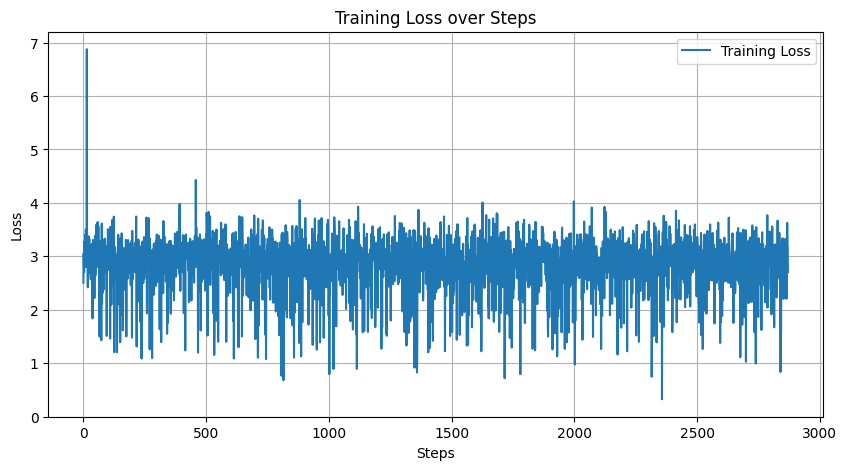

In [24]:
import matplotlib.pyplot as plt

# Plot the loss after training
plt.figure(figsize=(10, 5))
plt.plot(rl_trainer.model.train_loss, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss over Steps')
plt.legend()
plt.grid(True)
plt.savefig('training_loss_plot.png')  # Save the plot as a file
plt.show()